In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import linear_model
from scipy.optimize import line_search
from functools import reduce
from collections import defaultdict
from scipy.stats import multivariate_normal

h = 0.001

# Linear regression with gradient descent

In [3]:
#function-object for linear_search in bfgs-method implemented in next cells
def compute_gradient(f):
    def gradients(x):
        I = np.eye(len(x))
        return np.array([(f(x + h*I_) - f(x - h*I_))/(2.0*h) for I_ in I])
    return gradients

#numerical approximation of gradient with asymptotic precision o(h**2)
def gradient(f, x):
    I = np.eye(len(x))
    return np.array([(f(x + h*I_) - f(x - h*I_))/(2.0*h) for I_ in I])

#gradient method with dividing of step
def gradient_method(f, x, init_rate=0.1, delta=0.5, theta=0.001, max_iter=200):
    iteration = 1
    current_x = x
    while True:
        next_x = current_x - init_rate*gradient(f, current_x)
        rate = init_rate
        while f(next_x) - f(current_x) > -theta*rate*np.linalg.norm(gradient(f, current_x))**2: 
            rate = rate*delta
            next_x = current_x - rate*gradient(f, current_x)
        if max_iter < iteration: 
            break
        
        iteration += 1
        current_x = next_x
    return next_x

In [4]:
def linear_regression(train_data):
    cost_function = lambda x: 1.0/len(train_data)*np.sum((x[0] + x[1]*train_data[0] - train_data[1])**2) 
    params = gradient_method(cost_function, x=np.array([0.0, 0.0]))
    return params

## Generate simple train data for estimation and visualisation. 

### Linear regression is a consequence of maximum likelihood estimation, because cost function appears from maximization of likelihood function: we suppose that noise has centred normal distribution and compute product of probabilities of realization random variable (y = y_model + noise). After that we can see that MLE is equivalent to minimization squared norm with some coeff.

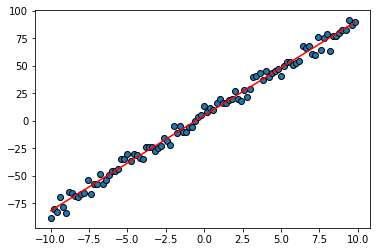

In [5]:
params = np.zeros(2)
params[0] = np.random.uniform(-10.0, 10.0)
params[1] = np.random.uniform(-10.0, 10.0)

noise_std = 5

possible_x = np.arange(-10.0, 10.0, 0.2)

train_data = np.array([[x, params[0] + params[1]*x + np.random.normal(scale=noise_std)] for x in possible_x])

estimated_params = linear_regression([train_data[:, 0], train_data[:, 1]])

plt.scatter(train_data[:, 0], train_data[:, 1], cmap='autumn', edgecolors='black', linewidth=1)
plt.plot(possible_x, estimated_params[0] + possible_x*estimated_params[1], 'r')
plt.show()

#if you see LineSearchWarning it's normal, because I used Wolfe's conditions in my BFGS method. 'LineSearchWarning'
#mean that my method has converged in the minimum and there anyone else

### I used house prices dataset from Kaggle and implement linear regression with some columns. For my purposes I created realisation of BFGS-algorithm, 'cause GD very slow and quasi-newton methods works better. 

In [6]:
frame = pd.read_csv('/home/vaden4d/Documents/dataroot/house_prices_dataset/train.csv')

train_x = np.array(frame.ix[frame.LotArea <= 50000]['LotArea'][:1400])
train_y = np.array(frame.ix[frame.LotArea <= 50000]['SalePrice'][:1400])

train_x = train_x / np.std(train_x)
train_y = train_y / np.std(train_y)

test_x = frame.ix[frame.LotArea <= 50000]['LotArea'][1400:]
test_y = frame.ix[frame.LotArea <= 50000]['SalePrice'][1400:]

FileNotFoundError: File b'/home/vaden4d/Documents/dataroot/house_prices_dataset/train.csv' does not exist

   ## Linear regression (with BFGS optimizer)

In [7]:
#linesearch use scipy-function for search in descent direction and found alpha that satisfies Wolfe conditions
def linesearch(f, x, direction):
    old_fval = f(x)
    gradient_f = compute_gradient(f)
    alpha = line_search(f, gradient_f, x, direction, old_fval=old_fval)[0]
    if alpha == None: 
        return None
    return x + alpha*direction

def bfgs_method(f, x, max_iter=20):
    I = np.eye(len(x))
    iteration = 1
    hesse = I.copy()
    current_x = x
    while True:
        current_direction = -np.dot(hesse, gradient(f, current_x))
        next_x = linesearch(f, current_x, current_direction)
        if iteration > max_iter or next_x == None: 
            return current_x
            
        increase_x = next_x - current_x
        increase_grad = gradient(f, next_x) - gradient(f, current_x)
        
        #some regularizations methods
        scale_coef = 1.0/np.dot(increase_x, increase_grad)
        if scale_coef > 1e+10: scale_coef = 1000
        
        hesse_next = reduce(np.dot, 
                            [
                            I - scale_coef*np.outer(increase_x, increase_grad),
                            hesse,
                            I - scale_coef*np.outer(increase_grad, increase_x)
                            ]
                            )
        hesse = hesse_next + scale_coef*np.outer(increase_x, increase_x)
        current_x = next_x
        iteration += 1
    return next_x

In [8]:
def linear_regression(train_data):
    cost_function = lambda x: 1.0/len(train_data)*np.sum((x[0] + x[1]*train_data[0] - train_data[1])**2) 
    params = bfgs_method(cost_function, x=np.array([0.0, 0.0]))
    return params

In [9]:
parameters = linear_regression([train_x, train_y])
print(parameters)

t1 = np.arange(0, np.max(train_x), 0.1)
plt.plot(train_x, train_y, 'ro')
plt.plot(t1, parameters[0] + t1*parameters[1], 'k')
plt.show()

NameError: name 'train_x' is not defined

## Compare with sklearn

In [10]:
regr = linear_model.LinearRegression()
regr.fit(np.array([[x] for x in train_x]), np.array(train_y))
print([regr.intercept_, regr.coef_[0]])

t1 = np.arange(0, np.max(train_x), 0.1)
plt.plot(train_x, train_y, 'ro')
plt.plot(t1, regr.intercept_ + t1*regr.coef_[0], 'k')
plt.show()

NameError: name 'train_x' is not defined

# Logistic regression (with BFGS optimizer)

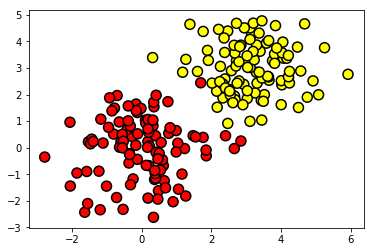

In [48]:
#generate data: two classes that contain groups of normal distributed values
train_data = np.random.normal(size=(100, 2), loc=0)
train_labels = np.zeros(100)

train_data = np.concatenate((train_data, np.random.normal(size=(100, 2), loc=3)))
train_labels = np.concatenate((train_labels, np.ones(100)))

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

### Logistic regression is simple to linear regression, but now we must lineary separate data. For better visualisation I optimized cost function and found coeficient of line and compare with separator from sklearn.

In [12]:
#some functions for cost function
def sigmoid(values, params):
    return 1.0/(1 + np.exp(-np.dot(values, params[1:])-params[0]))

def single_entropy(values, labels):
    return labels*np.log(values) + (1-labels)*np.log(1-values)

def logistic_regression(train_data):
    cost_function = lambda x: -1/len(train_data)*np.sum(single_entropy(sigmoid(train_data[0], x), train_data[1])) + np.linalg.norm(x)
    params = bfgs_method(cost_function, x=np.array([2.0, 2.0, 2.0]))
    return params

In [13]:
parameters = logistic_regression([train_data, train_labels])
print(parameters)

[-2.62776508  1.53626367  1.32029243]


/Users/Markos/anaconda/lib/python3.6/site-packages/ipykernel/__main__.py:18: FutureWarning: comparison to `None` will result in an elementwise object comparison in the future.
/Users/Markos/anaconda/lib/python3.6/site-packages/scipy/optimize/linesearch.py:285: LineSearchWarning: The line search algorithm did not converge
  warn('The line search algorithm did not converge', LineSearchWarning)


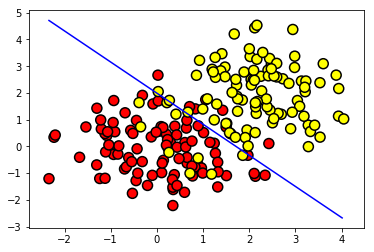

In [14]:
#visualize my separator
points_x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)

plt.plot(points_x, -parameters[0]/parameters[2]-points_x*parameters[1]/parameters[2], 'b')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

## Compare!

In [15]:
logreg = linear_model.LogisticRegression()
logreg.fit(train_data, train_labels)
print([logreg.intercept_, logreg.coef_[0]])

[array([-2.42744295]), array([ 1.43542757,  1.24735432])]


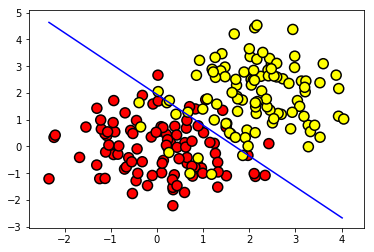

In [16]:
parameters = np.c_[logreg.intercept_, logreg.coef_][0]

points_x = np.arange(np.min(train_data[:, 0]), np.max(train_data[:, 0]), 0.05)

plt.plot(points_x, -parameters[0]/parameters[2]-points_x*parameters[1]/parameters[2], 'b')
plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, s=100, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

### Almost the same.

# Naive Bayes Classifier

In [17]:
from sklearn import datasets

iris = datasets.load_iris()

In [18]:
train_data = np.array(list([sample, label] for sample, label in zip(iris.data, iris.target)))
np.random.shuffle(train_data)

train_features = train_data[:, 0][:125]
train_labels = train_data[:, 1][:125]

test_features = train_data[:, 0][125:]
test_labels = train_data[:, 1][125:]
#my train and test data. of course, we can use train_test_split from, but I wrote my optional

In [ ]:
#naive bayes with counts
def naive_bayes(train_features, train_labels, sample):
    classes = defaultdict(lambda: 0)
    frequencies = defaultdict(lambda: 0)
    
    for features, label in zip(train_features, train_labels):
        classes[label] += 1.0             
        for feature in features:
            frequencies[feature, label] += 1.0        
 
    for feature, label in frequencies:             
        frequencies[feature, label] /= classes[label]
    for label in classes:                       
        classes[label] /= len(train_labels)

    results = np.array([])
    for label in set(train_labels):
        product = 1.0
        for new_feature in sample:
            product *= frequencies[new_feature, label]
        product *= classes[label]
        results = np.append(results, product)
    return np.argmax(results)

#accuracy of method with test set
def accuracy(train_features, train_labels, test_features, test_labels):
    accuracy = np.array([])
    for features, labels in zip(test_features, test_labels):
        accuracy = np.append(accuracy, naive_bayes(train_features, train_labels, features) == labels)
    return len(list(filter(lambda x: x == True, accuracy)))/len(test_labels)

In [ ]:
accuracy(train_features, train_labels, test_features, test_labels)

# K-Means (with Iris dataset)

In [ ]:
from sklearn.model_selection import train_test_split
data, labels = iris.data, iris.target

In [ ]:
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=labels)
plt.show()

In [ ]:
def find_center(x, centers):
    distances = np.array([np.linalg.norm(x-center) for center in centers])
    index = np.argmin(distances)
    return index

def k_means(train_data, num_of_clusters=3):
    current_centers = [[] for i in range(num_of_clusters)]
    next_centers = [[] for i in range(num_of_clusters)]
    for i in range(num_of_clusters):
        current_centers[i] = train_data[i]
    while True:
        clusters = [[] for i in range(num_of_clusters)]
        for feature in train_data:
            found_index = find_center(feature, current_centers)
            clusters[found_index].append(feature)
        for i in range(num_of_clusters):
            next_centers[i] = np.mean(clusters[i], axis=0)
        clusters = [np.array(cluster) for cluster in clusters]
        if set([tuple(next_center) for next_center in next_centers]) == set([tuple(current_center) for current_center in current_centers]): break
        next_centers = np.array(next_centers)
        current_centers = next_centers
    return clusters, next_centers

In [ ]:
#shuffled for random finding of the centers
for_shuffle = data[:, 2:4].copy()
np.random.shuffle(for_shuffle)
clusters, centres = k_means(for_shuffle)

In [ ]:
#compare with my method and real data
colormap = np.array(['magenta', 'yellow', 'cyan'])

plt.subplot(1, 2, 1)
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=colormap[labels])
plt.title('Real data')

plt.subplot(1, 2, 2)
plt.scatter(clusters[0][:, 0], clusters[0][:, 1])
plt.scatter(clusters[1][:, 0], clusters[1][:, 1])
plt.scatter(clusters[2][:, 0], clusters[2][:, 1])
plt.title('My K-Means data')
plt.show()

#compare real data and sklearn realization
colormap = np.array(['magenta', 'yellow', 'cyan'])

plt.subplot(1, 2, 1)
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=colormap[labels])
plt.title('Real data')

from sklearn.cluster import KMeans
clusterizer = KMeans(n_clusters=3)
clusterizer.fit(iris.data[:, 2:4])

plt.subplot(1, 2, 2)
plt.scatter(iris.data[:, 2], iris.data[:, 3], c=colormap[clusterizer.labels_])
plt.title('Sklearn K-Means data')
plt.show()

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(labels, np.sort(clusterizer.labels_))

# Gaussian discriminant analysis (or Linear discriminant analysis)

In [ ]:
#generate data: two classes that contain groups of normal distributed values
class_size_1 = 150
class_size_2 = 100

mean_1 = 0.0
mean_2 = 3.0

std_1 = 1.5
std_2 = 1.5

train_data = np.random.normal(size=(class_size_1, 2), loc=mean_1, scale=std_1)
train_labels = np.zeros(class_size_1)

train_data = np.concatenate((train_data, np.random.normal(size=(class_size_2, 2), loc=mean_2, scale=std_2)))
train_labels = np.concatenate((train_labels, np.ones(class_size_2)))

plt.scatter(train_data[:, 0], train_data[:, 1], c=train_labels, 
cmap='autumn', edgecolors='black', linewidth=1.5);
plt.show()

#generate test data
test_data = np.random.normal(size=(class_size_1 // 5, 2), loc=mean_1, scale=std_1)
test_labels = np.zeros(class_size_1 // 5)

test_data = np.concatenate((test_data, np.random.normal(size=(class_size_2 // 5, 2), loc=mean_2, scale=std_2)))
test_labels = np.concatenate((test_labels, np.ones(class_size_2 // 5)))

## Suppose:

### y ~ Bernoully(a)
### x | y=0 ~ N(m_1, cov)
### x | y=1 ~ N(m_2, cov)

In [ ]:
#compute means and cov 
def gda_method_computations(train_data, train_labels):
    classes = defaultdict(lambda: 0)
    for label in train_labels:
        classes[label] += 1.0/len(train_labels)
    
    first_mean_est = np.sum(np.compress(train_labels == 0, train_data, axis=0), axis=0)/len(np.extract(train_labels == 0, train_labels))
    second_mean_est = np.sum(np.compress(train_labels == 1, train_data, axis=0), axis=0)/len(np.extract(train_labels == 1, train_labels))
    
    means = [first_mean_est if train_labels[i] == 0 else second_mean_est for i in range(len(train_labels))]
    residuals = train_data - means
    
    cov_est = np.zeros((len(train_data[0]), len(train_data[0])))
    for element in residuals:
        cov_est += np.outer(element, element)
    cov_est /= len(train_labels)

    return classes, first_mean_est, second_mean_est, cov_est

#evaluate for two classes
def gda_method_evaluate(class_probability, first_mean, second_mean, cov, sample):
    result = np.array([])
    result = np.append(result, multivariate_normal.pdf(sample, first_mean, cov=cov) * class_probability[0])
    result = np.append(result, multivariate_normal.pdf(sample, second_mean, cov=cov) * class_probability[1])
    return np.argmax(result)

#accuracy of the test data
def gda_accuracy(class_probability, first_mean, second_mean, cov, test_data, test_labels):
    result = np.array([])
    for sample, label in zip(test_data, test_labels):
        result = np.append(result, gda_method_evaluate(class_probability, first_mean, second_mean, cov, sample) == label)
    return len(np.extract(result == 1, result))/len(test_labels)

In [ ]:
class_prob, f_mean, s_mean, cov = gda_method_computations(train_data, train_labels)

In [ ]:
gda_accuracy(class_prob, f_mean, s_mean, cov, test_data, test_labels)

### Compare with sklearn:

In [ ]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
clf = LinearDiscriminantAnalysis()
clf.fit(train_data, train_labels)

In [ ]:
predicted_labels = clf.predict(test_data)
accuracy_score(test_labels, predicted_labels)

## PCA (of course, with IRIS dataset)

In [ ]:
from sklearn import datasets

iris = datasets.load_iris()

train_data = iris.data[:, 1:4]
train_labels = iris.target

In [ ]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(iris.data[:, 1], iris.data[:, 2], iris.data[:, 3], c=iris.target)
plt.show()

In [ ]:
#pca for train_data
def decomposition(train_data, subspace_dim=2):
    #))))))))))))))))))))
    pass

In [ ]:
compr_data = decomposition(iris.data)

In [ ]:
#visualize
plt.scatter(compr_data[:, 0], compr_data[:, 1], c=train_labels)
plt.show()